In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

os.chdir('/content/drive/MyDrive/MeetfreshCV Group 3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 1: Prepare model and data
#### (a) load model

In [ ]:
from tensorflow.keras.models import load_model

model_epoch = 12
model = load_model('outputs/2.2_classifiers/2_model_{model_epoch:02d}.h5'.format(model_epoch = model_epoch))

In [ ]:
import shutil
!pip install split-folders
import splitfolders

# IN_DIR = 'data/data_aug'; ratio = (0.7, 0.2, 0.1)
IN_DIR = '/content/drive/MyDrive/MeetfreshCV Group 3/outputs/2.1_prediction_yolo'; ratio = (0.7, 0.2, 0.1)  ## ratio = (0.2, 0.4, 0.4)
OUT_DIR = '/content/drive/MyDrive/MeetfreshCV Group 3/data/yolo_treated_pics'

## empty out_dir if exist
if os.path.exists(os.path.join(OUT_DIR)):
  shutil.rmtree(OUT_DIR)

## split train, valid, test
splitfolders.ratio(IN_DIR, output = OUT_DIR, seed = 2022, ratio = ratio) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  5.85 files/s]
Copying files: 2 files [00:01,  1.37 files/s]
Copying files: 3 files [00:02,  1.05 files/s]
Copying files: 4 files [00:03,  1.01 files/s]
Copying files: 5 files [00:04,  1.02s/ files]
Copying files: 6 files [00:11,  2.96s/ files]
Copying files: 11 files [00:11,  1.05 files/s]
Copying files: 17 files [00:12,  2.27 files/s]
Copying files: 22 files [00:12,  3.64 files/s]
Copying files: 28 files [00:12,  5.85 files/s]
Copying files: 33 files [00:12,  8.17 files/s]
Copying files: 39 files [00:12, 11.79 files/s]
Copying files: 45 files [00:12, 16.09 files/s]
Copying files: 50 files [00:12, 19.81 files/s]
Copying files: 56 files [00:12, 25.24 files/s]
Copying files: 62 files [00:12, 28.51 files/s]
Copying files: 67 files [00:13, 21.74 files/s]
Copying files: 74 files [00:13, 28.27 files/s]
Copying files: 80 files [00:13, 32.83 files/s]
Copying files: 85 files [00:13, 34.60 files/s]
Copying files: 91 files

#### (b) image path

In [ ]:
## save image/box path as dataframe 
# skip this section
test_dir = '/content/drive/MyDrive/MeetfreshCV Group 3/data/data_model/test'
box_dir = 'drive/MyDrive/MeetfreshCV Group 3/outputs/2.1_prediction_yolo'

img_path = pd.DataFrame()
for folder in os.listdir(test_dir):
  files = os.listdir(os.path.join(test_dir, folder))
  img_path = img_path.append(
      pd.DataFrame({
          'file':  [os.path.join(test_dir, folder, file) for file in files], 
          'class': folder,
          'box': [os.path.join(box_dir, folder, 'labels', file.replace('JPG','txt')) for file in files]
          }))
img_path.head()

,file,class,box
0,/content/drive/MyDrive/MeetfreshCV Group 3/dat...,绿豆糕,drive/MyDrive/MeetfreshCV Group 3/outputs/2.1_...
1,/content/drive/MyDrive/MeetfreshCV Group 3/dat...,绿豆糕,drive/MyDrive/MeetfreshCV Group 3/outputs/2.1_...
2,/content/drive/MyDrive/MeetfreshCV Group 3/dat...,绿豆糕,drive/MyDrive/MeetfreshCV Group 3/outputs/2.1_...
3,/content/drive/MyDrive/MeetfreshCV Group 3/dat...,绿豆糕,drive/MyDrive/MeetfreshCV Group 3/outputs/2.1_...
4,/content/drive/MyDrive/MeetfreshCV Group 3/dat...,绿豆糕,drive/MyDrive/MeetfreshCV Group 3/outputs/2.1_...


In [5]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 100
IMG_SIZE = 100
IMG_DIR = 'data/yolo_treated_pics'

train = ImageDataGenerator(rescale = 1./255)
train_dataset = train.flow_from_directory(
    directory = IMG_DIR + '/train',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True)

valid = ImageDataGenerator(rescale = 1./255)
valid_dataset = valid.flow_from_directory(
    directory = IMG_DIR + '/val',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False)

test = ImageDataGenerator(rescale = 1./255)
test_dataset = test.flow_from_directory(
    directory = IMG_DIR + '/test',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False)

Found 1991 images belonging to 14 classes.
Found 564 images belonging to 14 classes.
Found 296 images belonging to 14 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

from keras.applications.xception import Xception

## set up base model
base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, 3))

## complete architecture
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu', use_bias = True))
model.add(Dense(14, activation = 'sigmoid'))

## freeze base weights
base_model.trainable = False 

## compile 
LR_RT = 1e-4
model.compile(
    optimizer = RMSprop(learning_rate = LR_RT),
    loss = 'categorical_crossentropy',   
    metrics = ['accuracy']) 

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

MODEL_DIR = 'outputs'

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3, 
    min_lr = 1e-7)

checkpoint = ModelCheckpoint(
    filepath = os.path.join(MODEL_DIR, '3y_models/3y_model_{epoch:02d}.h5'),
    monitor = 'val_acc',
    save_best_only = False,
    save_weights_only = False)

In [ ]:
EPOCHS = 20

start = time.time()
model.fit(
    train_dataset, 
    steps_per_epoch = train_dataset.n // BATCH_SIZE, 
    epochs = EPOCHS, 
    validation_data = valid_dataset,
    validation_steps = valid_dataset.n // BATCH_SIZE,
    callbacks = [reduce_lr, checkpoint]
)
end = time.time()
print(f'Running Time: {(end - start)/3600} hrs.')

Epoch 1/20
19/19 [==============================] - 1390s 73s/step - loss: 1.1365 - accuracy: 0.6378 - val_loss: 0.5952 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 2/20
19/19 [==============================] - 345s 18s/step - loss: 0.4433 - accuracy: 0.8805 - val_loss: 0.3759 - val_accuracy: 0.8920 - lr: 1.0000e-04
Epoch 3/20
19/19 [==============================] - 345s 18s/step - loss: 0.2856 - accuracy: 0.9270 - val_loss: 0.2704 - val_accuracy: 0.9300 - lr: 1.0000e-04
Epoch 4/20
19/19 [==============================] - 344s 18s/step - loss: 0.1859 - accuracy: 0.9545 - val_loss: 0.2366 - val_accuracy: 0.9340 - lr: 1.0000e-04
Epoch 5/20
19/19 [==============================] - 343s 18s/step - loss: 0.1257 - accuracy: 0.9725 - val_loss: 0.2321 - val_accuracy: 0.9340 - lr: 1.0000e-04
Epoch 6/20
19/19 [==============================] - 340s 18s/step - loss: 0.1182 - accuracy: 0.9714 - val_loss: 0.2425 - val_accuracy: 0.9340 - lr: 1.0000e-04
Epoch 7/20
19/19 [===========================

Running Time: 2.2797321099042893 hrs.


### Step 2: Predict

In [ ]:
##这里是网上找到的code，可以改一下 然后一张张predict img_path里的图片。
# skip this section
import cv2
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
for img_p in img_path.file:
    
    # Passing the entire path of the image file
    # file= os.path.join(img_path, filename)
    file = img_p
    
    # Load original via OpenCV, so we can draw on it and display it on our screen
    original = cv2.imread(file)

    image = image_utils.load_img(file, target_size=(224, 224))
    image = image_utils.img_to_array(image)

    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    print("[INFO] loading network...")
    model = VGG16(weights="imagenet")    # Load the VGG16 network pre-trained on the ImageNet dataset

    print("[INFO] classifying image...")
    predictions = model.predict(image)   # Classify the image (NumPy array with 1000 entries)
    P = decode_predictions(predictions)  # Get the ImageNet Unique ID of the label, along with human-readable label
    print(P)    

    # Loop over the predictions and display the rank-5 (5 epochs) predictions + probabilities to our terminal
    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

    original = cv2.imread(file)
    (imagenetID, label, prob) = P[0][0]
    cv2.putText(original, "Label: {}, {:.2f}%".format(label, prob * 100), (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    # cv2.imshow(original)  
    # cv2.waitKey(0) 

In [4]:
from tensorflow.keras.models import load_model

model_epoch = 20
model = load_model('outputs/3y_models/3y_model_{model_epoch:02d}.h5'.format(model_epoch = model_epoch))

In [6]:
predict = model.predict_generator(test_dataset,steps = 296)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [8]:
predict.shape

(296, 14)

In [13]:
# tb2 <- result from yolo treated pics
tb2 = pd.DataFrame({
    'true_label': test_dataset.classes,
    'file_name': test_dataset.filenames,
    # 'item': test_dataset.class_indices.keys(),
    'prediction': np.argmax(predict, axis = 1)
})
out = pd.concat(
    [
     tb2.groupby('true_label').apply(lambda tmp: np.mean(tmp['prediction'] == tmp['true_label'])),
     tb2.groupby('true_label').apply(lambda tmp: tmp.shape[0]),
     pd.Series(test_dataset.class_indices.keys())
    ], axis = 1)
out.iloc[12, 0] = 1
out.iloc[12, 1] = 0
out

,0,1,2
0,1.000000,11.0,Q麻薯拼盘
1,1.000000,6.0,原味冰淇凌鸡蛋仔
2,1.000000,29.0,双芋招牌
3,0.975610,41.0,小芋圆冬瓜茶
4,0.500000,6.0,小芋圆奶茶
5,0.818182,11.0,小芋圆豆花
6,0.846154,13.0,布丁Q麻薯牛奶冰
7,1.000000,32.0,抹茶鸡蛋仔
8,1.000000,36.0,杏仁布丁
9,1.000000,8.0,焦糖布丁


### Step 3: Check Performance

In [ ]:
## 这里是第一版CNN在test data上的表现
tb = pd.DataFrame({
    'true_label': test_dataset.classes,
    'file_name': test_dataset.filenames,
    # 'item': test_dataset.class_indices.keys(),
    'prediction': np.argmax(predict, axis = 1)
})
pd.concat(
    [
     tb.groupby('true_label').apply(lambda tmp: np.mean(tmp['prediction'] == tmp['true_label'])),
     tb.groupby('true_label').apply(lambda tmp: tmp.shape[0]),
     pd.Series(test_dataset.class_indices.keys())
    ], axis = 1)

,0,1,2
0,1.000000,11,Q麻薯拼盘
1,1.000000,6,原味冰淇凌鸡蛋仔
2,0.965517,29,双芋招牌
3,0.829268,41,小芋圆冬瓜茶
4,0.500000,6,小芋圆奶茶
5,1.000000,11,小芋圆豆花
6,0.769231,13,布丁Q麻薯牛奶冰
7,1.000000,32,抹茶鸡蛋仔
8,1.000000,36,杏仁布丁
9,1.000000,8,焦糖布丁


In [ ]:
c1 = tb['true_label'] == 6
c2 = tb['prediction'] != 6
tb[c1 & c2]

,true_label,file_name,prediction
104,6,布丁Q麻薯牛奶冰/105.JPG,2
105,6,布丁Q麻薯牛奶冰/24.JPG,0
114,6,布丁Q麻薯牛奶冰/71.JPG,5


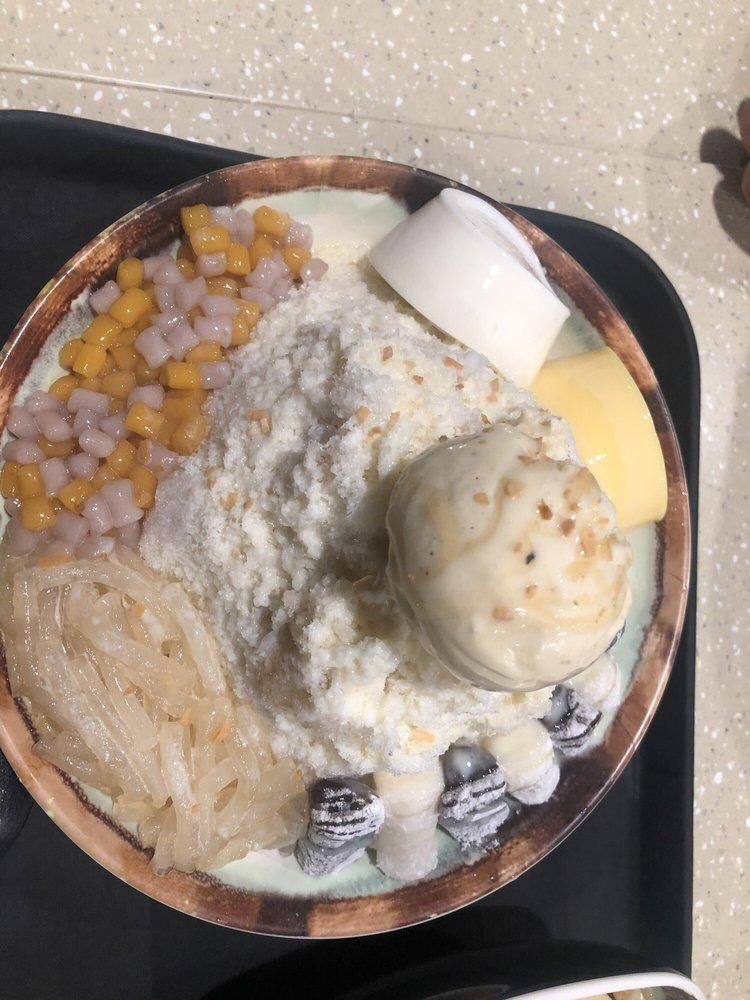

In [ ]:
from IPython.display import Image
Image(filename = 'data/data_jpg/布丁Q麻薯牛奶冰/105.JPG')